In [3]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using OffsetArrays: no_offset_view
using CairoMakie.Colors

[ Info: Oceananigans will use 4 threads


In [9]:
runnames = ["NIechoes-Q-Ek"]
foldernames = map(runnames) do runname
    "../../scratch/Project/$runname"
end
runlabels = ["Cooling"]
legendtitle = L"Ri";
b_levels = range(-0.002749, 0, 40)
ψ_levels = range(-1, 1, 12)
ψ_colors = [
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    RGB(1, 1, 1), 
    to_colormap(:PuOr)[1], 
    to_colormap(:PuOr)[1],
    to_colormap(:PuOr)[1]
]
VSP_colors = reverse(to_colormap(:curl))

# Vertical velocity slices and VSP

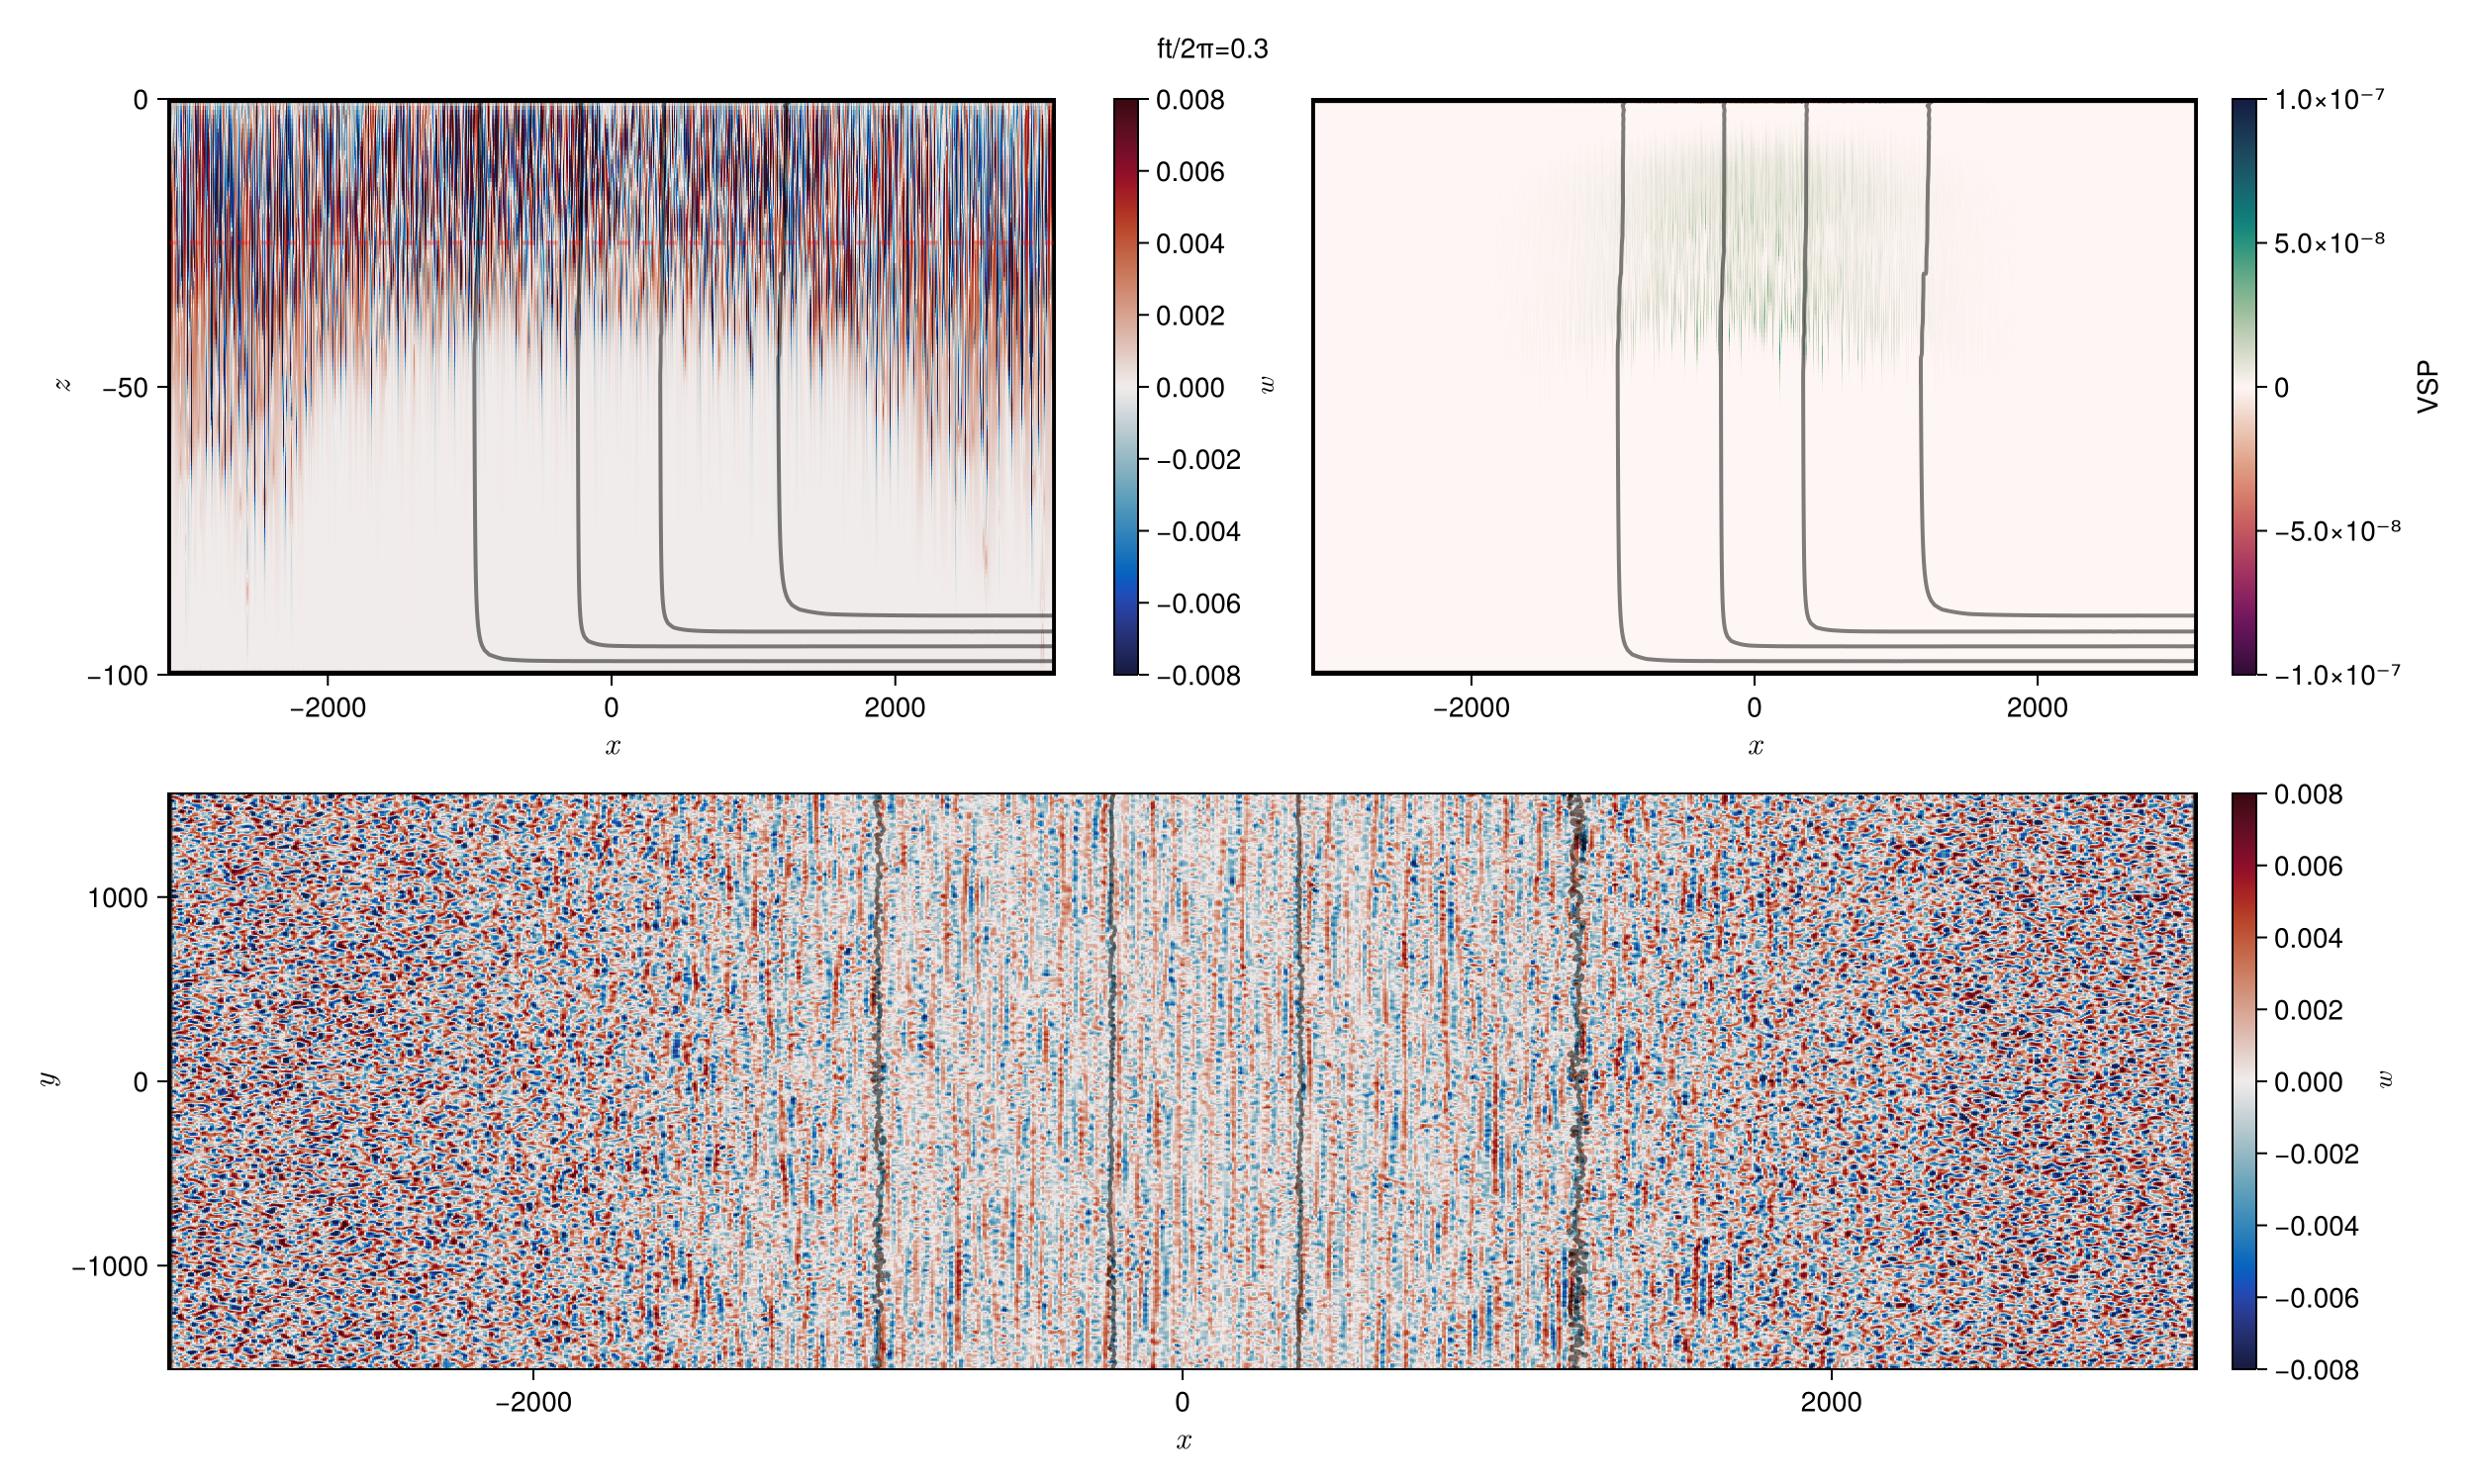

In [10]:
foldername = foldernames[1]
z = -25

run_time, sp = jldopen("$foldername/parameters.jld2") do file
    file["run_time"], file["simulation"]
end

xsᶜ, ysᶜ, zsᶜ, zsᶠ, iterations, ts = jldopen("$foldername/TKE.jld2") do file

    xsᶜ = no_offset_view(file["grid/xᶜᵃᵃ"])
    zsᶜ = no_offset_view(file["grid/zᵃᵃᶜ"])
    ysᶜ = no_offset_view(file["grid/yᵃᶜᵃ"])
    zsᶠ = no_offset_view(file["grid/zᵃᵃᶠ"])
    
    iterations = keys(file["timeseries/t"])
    ts = map(iteration->(sp.f * file["timeseries/t/$iteration"])/(2π), iterations)
    
    xsᶜ, ysᶜ, zsᶜ, zsᶠ, iterations, ts
end

slice = argmin(abs.(zsᶠ .- z))

n = Observable(20)

iteration = @lift iterations[$n]
t = @lift ts[$n]

VSP = @lift jldopen(file->no_offset_view(file["timeseries/VSP/$($iteration)"][:, 1, :]), "$foldername/TKE.jld2")
b_dfm = @lift jldopen(file->no_offset_view(file["timeseries/b_dfm/$($iteration)"][:, 1, :]), "$foldername/DFM.jld2")

w = @lift jldopen(file->no_offset_view(file["timeseries/w/$($iteration)"][:, 512, :]), "$foldername/initialisation.jld2")
b = @lift jldopen(file->no_offset_view(file["timeseries/b/$($iteration)"][:, 512, :]), "$foldername/initialisation.jld2")

w_slice =  @lift imfilter(jldopen(file->no_offset_view(file["timeseries/w/$($iteration)"])[:, :, slice], "$foldername/initialisation.jld2"), gaussian((1, 1)))
b_slice =  @lift imfilter(jldopen(file->no_offset_view(file["timeseries/b/$($iteration)"])[:, :, slice], "$foldername/initialisation.jld2"), gaussian((1, 1)))

title = @lift "ft/2π=$(round($t, digits=2))"

fig = Figure(; size=(1000, 600)./0.8, fontsize=14)
axis_kwargs = (; xlabel=L"x", ylabel=L"z", limits=(-sp.Lx/2, sp.Lx/2, -sp.H, 0), xlabelsize=16, ylabelsize=16)

ax_w = Axis(fig[1, 1]; axis_kwargs...)
ax_VSP = Axis(fig[1, 3]; axis_kwargs...)
ax_w_slice = Axis(fig[2, 1:3]; xlabel=L"x", ylabel=L"y", limits=(-sp.Lx/2, sp.Lx/2, -sp.Ly/2, sp.Ly/2), xlabelsize=16, ylabelsize=16)

w_max = 0.008
VSP_max = 1e-7
ht_w = heatmap!(ax_w, xsᶜ, zsᶠ, w; colormap=:balance, colorrange=(-w_max, w_max))
ht_VSP = heatmap!(ax_VSP, xsᶜ, zsᶜ, VSP; colormap=VSP_colors, colorrange=(-VSP_max, VSP_max))
contour!(ax_VSP, xsᶜ, zsᶜ, b_dfm; color=(:black, 0.5), levels=b_levels, linewidth=2)
contour!(ax_w, xsᶜ, zsᶜ, b_dfm; color=(:black, 0.5), levels=b_levels, linewidth=2)
lines!(ax_w, [xsᶜ[1], xsᶜ[end]], [z, z]; color=(:red, 0.3), linestyle=:dash, linewidth=2)

heatmap!(ax_w_slice, xsᶜ, ysᶜ, w_slice; colormap=:balance, colorrange=(-w_max/2, w_max/2))
contour!(ax_w_slice, xsᶜ, ysᶜ, b_slice; color=(:black, 0.5), levels=b_levels, linewidth=2)

Colorbar(fig[1, 2], ht_w; label=L"w")
Colorbar(fig[2, 4], ht_w; label=L"w")
Colorbar(fig[1, 4], ht_VSP; label="VSP")
hideydecorations!.(ax_VSP)
colgap!(fig.layout, 1, 30)
#colgap!(fig.layout, 2, 30)
Label(fig[0, :], title)
fig


#record(fig, "../output/videos/w_slice-Ek.mp4", 1:length(iterations); framerate=6) do i
#    n[] = i
#    print("$i\r")
#end

# Front state and potential vorticity

In [70]:
foldername = foldernames[1]
run_time, sp = jldopen("$foldername/parameters.jld2") do file
    file["run_time"], file["simulation"]
end
xs, zs, iterations, ts = jldopen("$foldername/DFM.jld2") do file
    iterations = keys(file["timeseries/t"])
    ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
    # All of these fields are on Center, Nothing, Center
    xs = no_offset_view(file["grid/xᶜᵃᵃ"])
    zs = no_offset_view(file["grid/zᵃᵃᶜ"])
    xs, zs, iterations, ts
end

n = Observable(1)

iteration = @lift iterations[$n]
t = @lift ts[$n]

v_dfm = @lift jldopen(file->no_offset_view(file["timeseries/v_dfm/$($iteration)"][:, 1, :]), "$foldername/DFM.jld2")
b_dfm = @lift jldopen(file->no_offset_view(file["timeseries/b_dfm/$($iteration)"][:, 1, :]), "$foldername/DFM.jld2")
q_dfm = @lift jldopen(file->no_offset_view(file["timeseries/q_dfm/$($iteration)"][:, 1, :]), "$foldername/PV.jld2")
ψ = @lift jldopen(file->no_offset_view(file["timeseries/ψ/$($iteration)"][:, 1, :]), "$foldername/DFM.jld2")

title = @lift "t/2π=$(round($t, digits=2))"

v_max=0.2
q_max=1e-9

fig = Figure(; size=(1000, 600)./1.3, fontsize=14)
axis_kwargs = (; xlabel=L"x", ylabel=L"z", limits=(-sp.Lx/2, sp.Lx/2, -sp.H, 0), xlabelsize=16, ylabelsize=16)

ax_v = Axis(fig[2, 1]; axis_kwargs..., title=L"\overline{v}")
ax_q = Axis(fig[2, 2]; axis_kwargs..., title=L"\overline{q}")
hideydecorations!(ax_q)

ht_v = heatmap!(ax_v, xs, zs, v_dfm, colormap=:balance, colorrange=(-v_max, v_max))
contour!(ax_v, xs, zs, b_dfm; color=(:black, 0.5), levels=b_levels, linewidth=2)
contour!(ax_v, xs, zs, ψ; colormap=ψ_colors, linestyle=:dash, levels=ψ_levels, linewidth=1.5)

ht_q = heatmap!(ax_q, xs, zs, q_dfm, colormap=:balance, colorrange=(-q_max, q_max), highclip=to_colormap(:balance)[end])
contour!(ax_q, xs, zs, b_dfm; color=(:black, 0.5), levels=b_levels, linewidth=2)
#contour!(ax_q, xs, zs, ψ; colormap=ψ_colors, linestyle=:dash, levels=ψ_levels, linewidth=1.5)

Colorbar(fig[3, 1], ht_v; vertical=false)
Colorbar(fig[3, 2], ht_q; vertical=false)

Label(fig[1, :], title)
rowgap!(fig.layout, 1, 0)
colgap!(fig.layout, 50)
fig

record(fig, "../output/videos/v_cooling.mp4", 1:length(iterations); framerate=6) do i
    n[] = i
    print("$i\r")
end

"../output/videos/v_cooling.mp4"

In [56]:
fig = let foldernames = foldernames[1:1]
    fig = Figure(; size=(1000, 300)./1.3, fontsize=14)
    map(enumerate(foldernames)) do (i, foldername)
        # Get parameters 
        run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["run_time"], file["simulation"]
        end
        
        domain = (-sp.Lx, 0, -0.90sp.H, -0.1sp.H)
        
        # Compute the integrals
        ts, ∇²ψ_tt, Lψ = jldopen("$foldername/PSI_nice.jld2") do file
            iterations = keys(file["timeseries/t"])[2:end-1]
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            
            Δz = reshape(no_offset_view(file["grid/Δzᵃᵃᶜ"]), 1, sp.Nz + 6)
            Δx = file["grid/Δxᶜᵃᵃ"]
            
            Ly = file["grid/Ly"]
            
            x_inds = domain[1] .< no_offset_view(file["grid/xᶜᵃᵃ"]) .< domain[2]
            z_inds = domain[3] .< no_offset_view(file["grid/zᵃᵃᶜ"]) .< domain[4]
            
            Lψ = map(iterations) do iteration
                a = no_offset_view(file["timeseries/Lψ/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            ∇²ψ_tt = map(iterations) do iteration
                a = no_offset_view(file["timeseries/∇²ψ_tt/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            ts, ∇²ψ_tt, Lψ
        end
        F_nl, F_other, F_VSP, F_BFLUX = jldopen("$foldername/PSI_notnice.jld2") do file
            iterations = keys(file["timeseries/t"])[2:end-1]
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            
            Δz = reshape(no_offset_view(file["grid/Δzᵃᵃᶜ"]), 1, sp.Nz + 6)
            Δx = file["grid/Δxᶜᵃᵃ"]
            
            Ly = file["grid/Ly"]
            
            x_inds = domain[1] .< no_offset_view(file["grid/xᶜᵃᵃ"]) .< domain[2]
            z_inds = domain[3] .< no_offset_view(file["grid/zᵃᵃᶜ"]) .< domain[4]
            
            F_nl = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_nl/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_other = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_other/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_VSP = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_VSP/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_BFLUX = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_BFLUX/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_nl, F_other, F_VSP, F_BFLUX
        end
        
        # Plot
        ax = Axis(fig[1, i];
            xlabel=L"t / 2\pi", 
            ylabel=L"\frac{\text{d}^2 C_{\text{IML}}}{\text{d}t^2}",
            title=L"Ri_\text{min}=%$(round(sp.Ri, digits=2))",
            limits=(0, 4, -0.55, 0.55),
            xlabelsize=16, ylabelsize=16, titlesize=16
        )
        lns = [
            lines!(ax, ts, -∇²ψ_tt; color=:black),
            lines!(ax, ts, -Lψ),
            lines!(ax, ts, F_VSP + F_BFLUX + 0F_other),
            lines!(ax, ts, -Lψ + F_VSP + F_BFLUX + 0F_other)
        ]
        
        i != 1 && hideydecorations!(ax, grid=false)
        
        # Add a legend for the last one
        i == length(foldernames) && Legend(fig[1, i+1], lns, [L"\frac{\text{d}^2 C_{\text{IML}}}{\text{d}t^2}", L"-L\psi", L"G", L"-L\psi + G"])
        
    end
    fig
end
#save("../output/paper_figures/streamfunction_evolution_figure.png", fig; px_per_unit=2)
fig

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/twZ5D/src/JLD2.jl:298


LoadError: SystemError: opening file "../../scratch/Project/NIechoes-Ek0/PSI_nice.jld2": No such file or directory